In [1]:
#To fetch data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
import numpy as np
from PIL import Image, ImageEnhance
dataset=[]
label=[]

#Fetch Data and freom yes and no folders
image_path= '/content/drive/MyDrive/AML Project/binary_brain_tumor/datasets/'
no_tumor= os.listdir(image_path+'no/')
yes_tumor= os.listdir(image_path+'yes/')

#create dataset with images as np.array and label array for training and testing
for i, image_name in enumerate(no_tumor):
  if(image_name.split('.')[1]=='jpg'):
    image= cv2.imread(image_path+'no/'+image_name)
    image= Image.fromarray(image, 'RGB')
    image=image.resize((64, 64)) 
    dataset.append(np.array(image))
    label.append(0)

for i, image_name in enumerate(yes_tumor):
  if(image_name.split('.')[1]=='jpg'):
    image= cv2.imread(image_path+'yes/'+image_name)
    image= Image.fromarray(image, 'RGB')
    image=image.resize((64, 64)) 
    dataset.append(np.array(image))
    label.append(1)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


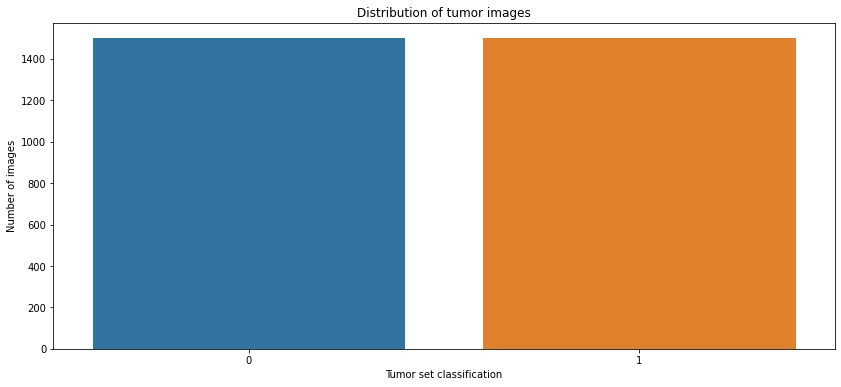

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

#plot the data distribution
plt.figure(figsize=(14,6))
sns.countplot(label)
plt.title('Distribution of tumor images')
plt.xlabel('Tumor set classification')
plt.ylabel('Number of images');

In [5]:
print(len(label))
from sklearn.model_selection import train_test_split
import random

#function to enhance images, on brightness, contrast and sharpness
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image
new_dataset=[]
for img in dataset:
  new_dataset.append(augment_image(img))

#new dataset is the enahnced images and dataset is the normal images

#new_dataset=np.array(new_dataset)
dataset=np.array(dataset)
label= np.array(label)

x_train, x_test, y_train, y_test= train_test_split(dataset, label, test_size=0.2, random_state=0)
print(x_train.shape)

3000
(2400, 64, 64, 3)


In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

x_train= normalize(x_train, axis=1)
x_test= normalize(x_test, axis=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                    

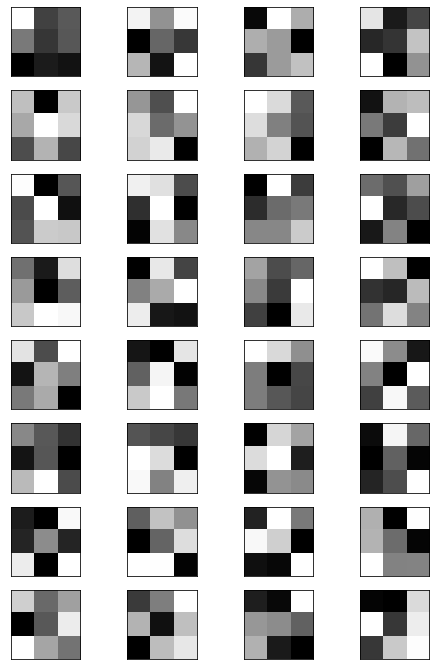

Epoch 1/10
150/150 [==============================] - 10s 6ms/step - loss: 0.5044 - accuracy: 0.7558 - val_loss: 0.4464 - val_accuracy: 0.8117
Epoch 2/10
150/150 [==============================] - 1s 4ms/step - loss: 0.3739 - accuracy: 0.8496 - val_loss: 0.3191 - val_accuracy: 0.8567
Epoch 3/10
150/150 [==============================] - 1s 5ms/step - loss: 0.2602 - accuracy: 0.8933 - val_loss: 0.2010 - val_accuracy: 0.9233
Epoch 4/10
150/150 [==============================] - 1s 5ms/step - loss: 0.1837 - accuracy: 0.9388 - val_loss: 0.1497 - val_accuracy: 0.9450
Epoch 5/10
150/150 [==============================] - 1s 5ms/step - loss: 0.1211 - accuracy: 0.9563 - val_loss: 0.1080 - val_accuracy: 0.9517
Epoch 6/10
150/150 [==============================] - 1s 4ms/step - loss: 0.0941 - accuracy: 0.9692 - val_loss: 0.0899 - val_accuracy: 0.9650
Epoch 7/10
150/150 [==============================] - 1s 5ms/step - loss: 0.0792 - accuracy: 0.9712 - val_loss: 0.0718 - val_accuracy: 0.9767
Epoch

In [7]:
#build a sequential model
INPUT_SIZE=64
model= Sequential()

model.add(Conv2D(32, (3,3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size =(2,2)))


model.add(Conv2D(64, (3,3),kernel_initializer='he_uniform')) #kernel initializer initializes the weights
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

#get layers and filters from model to visualize the initial 3 X 3 kernels used by CNN layer
layer= model.layers
filters, biases= model.layers[0].get_weights()
print(layer[0].name, filters.shape) #filter shape (3, 3, 3, 32) <-- 3 X 3== kernel size, 3== RGB channels, 32== number of filters for that convolutional layer, here layer[0]

#plot the kernels
fig1=plt.figure(figsize=(8, 12))
columns = 4
rows = 8
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()   

#train the model
history=model.fit(x_train, y_train, batch_size=16, verbose= 1, epochs=10, validation_data=(x_test, y_test), shuffle=False)

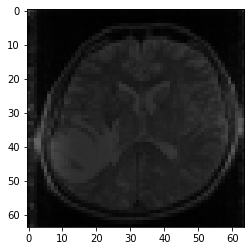

(1, 64, 64, 3)

In [8]:
#fetch a random input image to perform CNN and understand layer outputs of hidden layers
img = x_train[1800]
img= keras.utils.img_to_array(img)
plt.imshow(img)
plt.show()
img= np.expand_dims(img, axis=0)
img.shape

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________

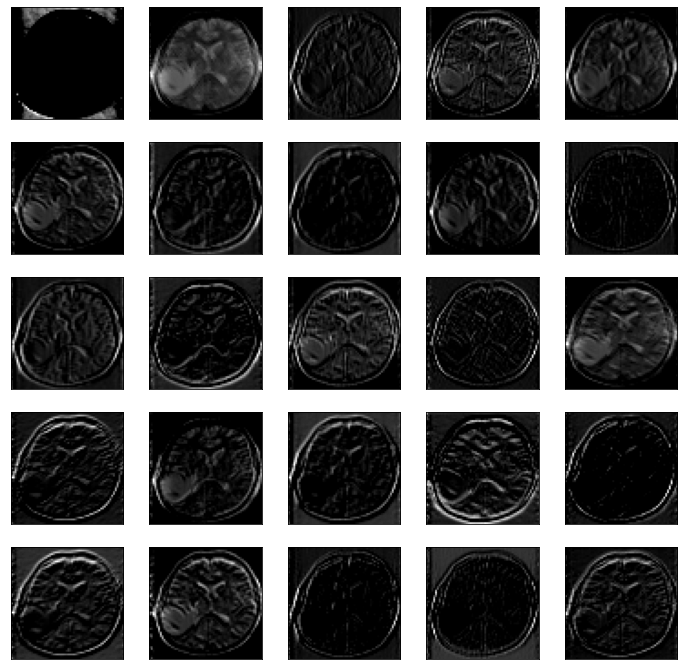

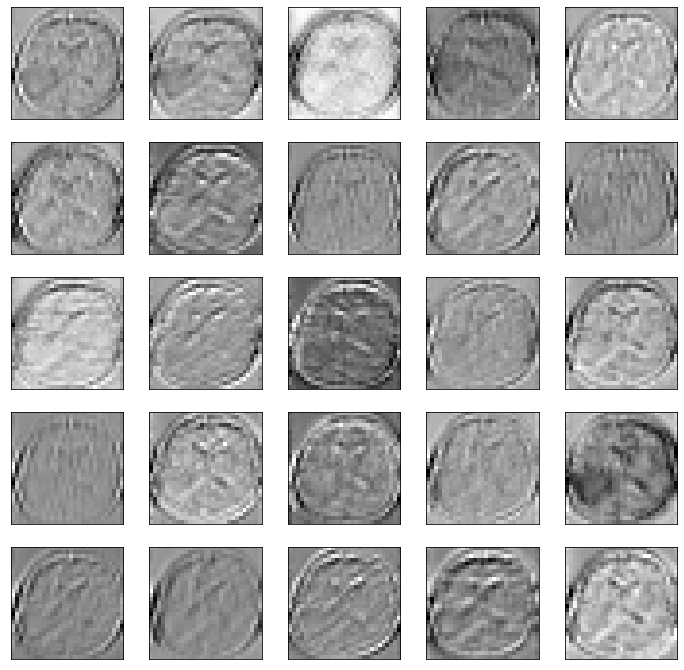

In [9]:
#Define a shorter model to visualize outputs of the inner layers of CNN

conv_layer_index = [1, 3]  #TO define a shorter model
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

#perform CNN on only one image img
feature_out= model_short.predict(img)
columns = 5
rows = 5
for ftr in feature_out:
    #pos = 1
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
        #pos += 1
    plt.show()

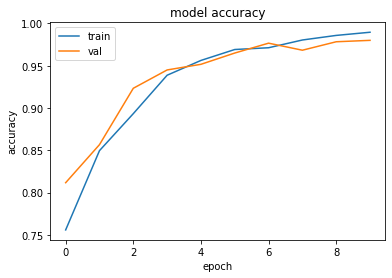

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
19/19 [==============================] - 0s 5ms/step


In [10]:
#plot model accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print(history.history.keys())

predictions=model.predict(x_test)

[3, 140]


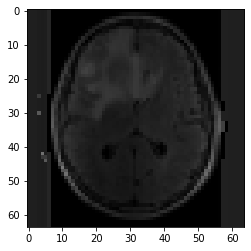

0.0033333333333333335


600

In [11]:
#make predictions and save to perform error analysis and plot confusion matrix

import matplotlib.pyplot as plt
new_pred=[]
for i in predictions:
  if(i<=0.5):
    new_pred.append(0)
  else:
    new_pred.append(1)

error_index=[]
for i in range(0, len(new_pred)):
  if(y_test[i]!=new_pred[i]):
    if(new_pred[i]==0):
      error_index.append(i)

print(error_index)

plt.imshow(x_test[90])
plt.show()

#example of image failed by the model
print(len(error_index)/len(x_test))
len(x_test)

[[333  10]
 [  2 255]]


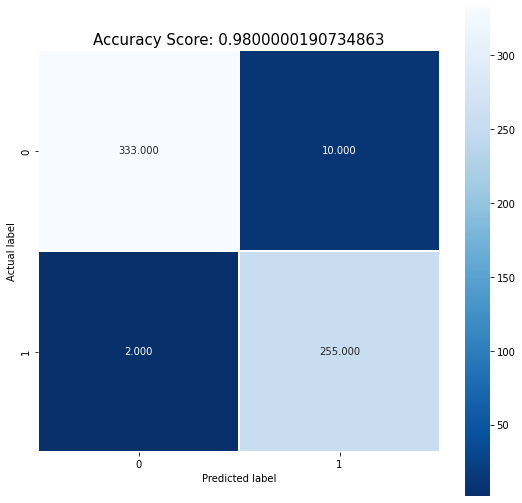

In [12]:
#plot confusion matrix
from sklearn import metrics

Confusion_Matrix = metrics.confusion_matrix(y_test, new_pred)
print(Confusion_Matrix)

plt.figure(figsize=(9,9))
sns.heatmap(Confusion_Matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(history.history['val_accuracy'][-1])
plt.title(all_sample_title, size = 15);

In [13]:
#classification report
print(metrics.classification_report(y_test, new_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       343
           1       0.96      0.99      0.98       257

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

